Analyzing stocks: 100%|██████████| 500/500 [00:16<00:00, 31.06it/s]


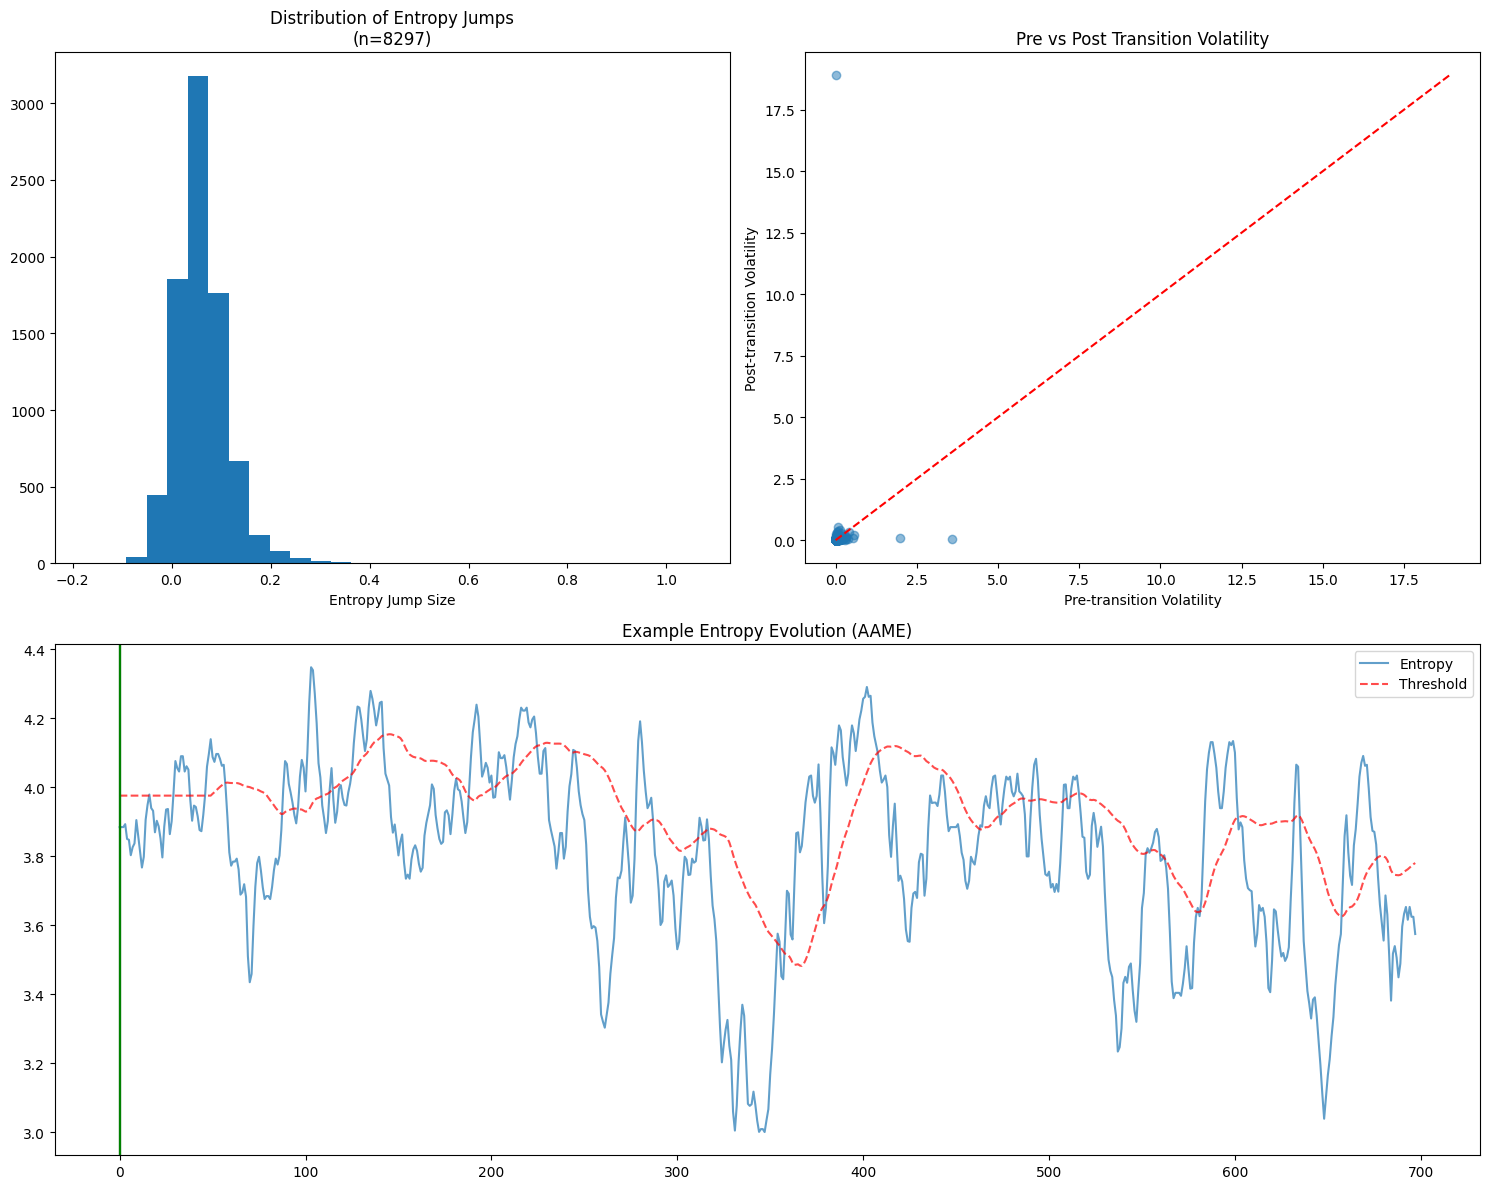


Analysis Results:
--------------------------------------------------
Total stocks analyzed: 500
Stocks with transitions: 500
Total transitions detected: 8297
Average transitions per stock: 16.59
Average volatility ratio (post/pre): infx
Average entropy jump: 0.059

Transition Pattern Statistics:
--------------------------------------------------
       pre_volatility  post_volatility  entropy_jump  volatility_ratio  \
count     8297.000000      8297.000000   8297.000000       8296.000000   
mean         0.028213         0.029135      0.059070               inf   
std          0.050422         0.208284      0.055405               NaN   
min          0.000000         0.000000     -0.173827          0.013150   
25%          0.013919         0.013786      0.025714          0.748215   
50%          0.021638         0.021071      0.048193          0.981481   
75%          0.034626         0.033847      0.082857          1.296145   
max          3.572277        18.891383      1.066185       

In [3]:
import pandas as pd
import numpy as np
from scipy import stats, signal
import glob
import os
from typing import Tuple, Dict
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class AdaptiveEntropyAnalyzer:
    def __init__(self, window_size: int = 50, smoothing_window: int = 3):
        self.window_size = window_size
        self.smoothing_window = smoothing_window
        
    def calculate_entropy(self, data: np.array, bins: int = 100) -> float:
        """Calculate Shannon entropy of the data"""
        hist, _ = np.histogram(data, bins=bins)
        hist = hist[hist > 0]
        probs = hist / hist.sum()
        return -np.sum(probs * np.log2(probs))
    
    def calculate_adaptive_threshold(self, entropy_series: np.array, 
                                  lookback: int = 50) -> np.array:
        """Calculate adaptive threshold using rolling statistics"""
        rolling_mean = pd.Series(entropy_series).rolling(lookback).mean()
        rolling_std = pd.Series(entropy_series).rolling(lookback).std()
        
        # More sensitive threshold - using 0.5 std instead of 1.5
        threshold = rolling_mean + 0.5 * rolling_std
        
        # Fill initial NaN values with first valid threshold
        threshold = threshold.fillna(method='bfill')
        return threshold.values

    def analyze_stock(self, returns: np.array) -> Tuple[np.array, Dict]:
        """Analyze a single stock's entropy patterns"""
        # Calculate rolling entropy
        entropy_values = []
        for i in range(len(returns) - self.window_size + 1):
            window_data = returns[i:i+self.window_size]
            entropy = self.calculate_entropy(window_data)
            entropy_values.append(entropy)
        
        entropy_series = np.array(entropy_values)
        smoothed_entropy = signal.savgol_filter(entropy_series, 
                                              self.smoothing_window, 3)
        
        # Calculate adaptive threshold
        threshold = self.calculate_adaptive_threshold(smoothed_entropy)
        
        # Identify zones - now using crossovers instead of pure threshold
        entropy_diff = np.diff(smoothed_entropy)
        threshold_diff = np.diff(threshold)
        
        # Identify significant entropy increases
        transition_points = np.where(
            (entropy_diff > np.std(entropy_diff)) & 
            (smoothed_entropy[1:] > threshold[1:])
        )[0]
        
        # Filter out transitions too close to each other
        min_distance = self.window_size
        filtered_transitions = []
        for i, point in enumerate(transition_points):
            if i == 0 or point - filtered_transitions[-1] >= min_distance:
                filtered_transitions.append(point)
        
        transitions = np.array(filtered_transitions)
        
        # Analyze zones
        zones = self._analyze_zones(returns, smoothed_entropy, transitions)
        
        return smoothed_entropy, threshold, zones
    
    def _analyze_zones(self, returns: np.array, entropy: np.array,
                      transition_points: np.array) -> Dict:
        """Analyze characteristics of different entropy zones"""
        zones = {
            'transitions': []
        }
        
        for point in transition_points:
            if point - self.window_size >= 0 and point + self.window_size < len(returns):
                transition = self._analyze_transition(
                    returns[point-self.window_size:point+self.window_size],
                    entropy[point-self.window_size:point+self.window_size],
                    point
                )
                zones['transitions'].append(transition)
        
        return zones
    
    def _analyze_transition(self, returns: np.array, entropy: np.array,
                          transition_point: int) -> Dict:
        """Analyze characteristics around transition point"""
        mid = len(returns) // 2
        pre_returns = returns[:mid]
        post_returns = returns[mid:]
        
        return {
            'pre_volatility': np.std(pre_returns),
            'post_volatility': np.std(post_returns),
            'entropy_jump': entropy[mid] - entropy[mid-1],
            'volatility_ratio': np.std(post_returns) / np.std(pre_returns),
            'pre_autocorr': pd.Series(pre_returns).autocorr(),
            'post_autocorr': pd.Series(post_returns).autocorr(),
            'jump_magnitude': np.abs(post_returns[0] - pre_returns[-1])
        }

def analyze_market_patterns():
    """Main analysis function"""
    # Load data
    data_path = 'Data/PriceData'
    parquet_files = glob.glob(os.path.join(data_path, '*.parquet'))
    
    # Initialize analyzer
    analyzer = AdaptiveEntropyAnalyzer(window_size=20, smoothing_window=5)
    
    # Analyze all stocks
    results = {}
    transition_patterns = []
    
    for file in tqdm(parquet_files[:500], desc="Analyzing stocks"):  # Limit to 500 stocks for testing
        try:
            symbol = os.path.basename(file).replace('.parquet', '')
            df = pd.read_parquet(file)
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.sort_values('Date')
            
            if len(df) < 252:  # Skip if less than 1 year of data
                continue
                
            returns = df['Close'].pct_change().dropna().values
            entropy, threshold, zones = analyzer.analyze_stock(returns)
            
            results[symbol] = {
                'entropy': entropy,
                'threshold': threshold,
                'zones': zones
            }
            
            # Collect transition patterns
            for transition in zones['transitions']:
                transition['symbol'] = symbol
                transition_patterns.append(transition)
                
        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")
    
    # Convert to DataFrame for analysis
    pattern_df = pd.DataFrame(transition_patterns)
    
    # Calculate statistics
    stats = {
        'total_stocks': len(results),
        'stocks_with_transitions': len(pattern_df['symbol'].unique()),
        'total_transitions': len(pattern_df),
        'avg_transitions_per_stock': len(pattern_df) / len(results) if results else 0,
        'avg_volatility_ratio': pattern_df['volatility_ratio'].mean() if not pattern_df.empty else 0,
        'avg_entropy_jump': pattern_df['entropy_jump'].mean() if not pattern_df.empty else 0
    }
    
    # Plot results
    plt.figure(figsize=(15, 12))
    
    # Plot 1: Distribution of entropy jumps
    plt.subplot(221)
    if not pattern_df.empty:
        plt.hist(pattern_df['entropy_jump'], bins=30)
        plt.title(f'Distribution of Entropy Jumps\n(n={len(pattern_df)})')
        plt.xlabel('Entropy Jump Size')
    
    # Plot 2: Pre vs Post Volatility
    plt.subplot(222)
    if not pattern_df.empty:
        plt.scatter(pattern_df['pre_volatility'], pattern_df['post_volatility'], alpha=0.5)
        max_vol = max(pattern_df['pre_volatility'].max(), pattern_df['post_volatility'].max())
        plt.plot([0, max_vol], [0, max_vol], 'r--')
        plt.title('Pre vs Post Transition Volatility')
        plt.xlabel('Pre-transition Volatility')
        plt.ylabel('Post-transition Volatility')
    
    # Plot 3: Example stock
    plt.subplot(212)
    if results:
        example_symbol = list(results.keys())[0]
        example_data = results[example_symbol]
        plt.plot(example_data['entropy'], label='Entropy', alpha=0.7)
        plt.plot(example_data['threshold'], 'r--', label='Threshold', alpha=0.7)
        
        # Mark transitions
        transitions = example_data['zones']['transitions']
        for t in transitions:
            plt.axvline(x=t['transition_point'] if 'transition_point' in t else 0, 
                       color='g', alpha=0.3)
        
        plt.title(f'Example Entropy Evolution ({example_symbol})')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results, pattern_df, stats

if __name__ == "__main__":
    results, patterns, statistics = analyze_market_patterns()
    
    print("\nAnalysis Results:")
    print("-" * 50)
    print(f"Total stocks analyzed: {statistics['total_stocks']}")
    print(f"Stocks with transitions: {statistics['stocks_with_transitions']}")
    print(f"Total transitions detected: {statistics['total_transitions']}")
    print(f"Average transitions per stock: {statistics['avg_transitions_per_stock']:.2f}")
    print(f"Average volatility ratio (post/pre): {statistics['avg_volatility_ratio']:.2f}x")
    print(f"Average entropy jump: {statistics['avg_entropy_jump']:.3f}")
    
    if not patterns.empty:
        print("\nTransition Pattern Statistics:")
        print("-" * 50)
        print(patterns.describe())

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats, signal
import glob
import os
from typing import Tuple, Dict, List
from tqdm import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
import warnings
from scipy.stats import gaussian_kde



warnings.filterwarnings('ignore')

@dataclass
class PredictionResult:
    date: pd.Timestamp
    predicted_direction: int
    actual_direction: int
    entropy_change: float
    volatility_ratio: float
    price_trend: float
    forward_return: float

class EntropyConsolidationPredictor:
    def __init__(self, 
                 entropy_window: int = 20,
                 trend_window: int = 50,
                 entropy_change_threshold: float = -0.15,  # More stringent
                 vol_ratio_threshold: float = 0.7,         # More stringent
                 forward_period: int = 5,
                 min_trend_strength: float = 0.02):        # Minimum trend strength
        
        self.entropy_window = entropy_window
        self.trend_window = trend_window
        self.entropy_change_threshold = entropy_change_threshold
        self.vol_ratio_threshold = vol_ratio_threshold
        self.forward_period = forward_period
        self.min_trend_strength = min_trend_strength

    def calculate_entropy(self, data: np.array, bins: int = 100) -> float:
        hist, _ = np.histogram(data, bins=bins)
        hist = hist[hist > 0]
        probs = hist / hist.sum()
        return -np.sum(probs * np.log2(probs))
    
    def detect_consolidation(self, df: pd.DataFrame) -> List[PredictionResult]:
        predictions = []
        entropy_values = []
        
        for i in range(self.entropy_window, len(df) - self.forward_period):
            current_window = df['returns'].iloc[i - self.entropy_window:i]
            prev_window = df['returns'].iloc[i - 2 * self.entropy_window:i - self.entropy_window]
            
            current_entropy = self.calculate_entropy(current_window)
            prev_entropy = self.calculate_entropy(prev_window)
            entropy_values.append(current_entropy)
            
            if len(entropy_values) < 2:
                continue
            
            entropy_change = (current_entropy - prev_entropy) / prev_entropy
            current_vol = np.std(current_window)
            historical_vol = np.std(df['returns'].iloc[max(0, i - self.trend_window):i])
            vol_ratio = current_vol / historical_vol if historical_vol != 0 else 1
            price_trend = (df['Close'].iloc[i] / df['Close'].iloc[i - self.trend_window] - 1) \
                         if i >= self.trend_window else 0
            
            if (entropy_change < self.entropy_change_threshold and 
                vol_ratio < self.vol_ratio_threshold and
                abs(price_trend) > self.min_trend_strength):
                
                future_price = df['Close'].iloc[i + self.forward_period]
                current_price = df['Close'].iloc[i]
                forward_return = (future_price - current_price) / current_price
                
                predicted_direction = np.sign(price_trend)
                actual_direction = np.sign(forward_return)
                
                predictions.append(PredictionResult(
                    date=df.index[i],
                    predicted_direction=predicted_direction,
                    actual_direction=actual_direction,
                    entropy_change=entropy_change,
                    volatility_ratio=vol_ratio,
                    price_trend=price_trend,
                    forward_return=forward_return
                ))
        
        return predictions

def analyze_consolidation_predictions(data_path: str = 'Data/PriceData'):
    filenumber = 1000
    predictor = EntropyConsolidationPredictor()
    all_predictions = []
    stock_results = {}
    
    parquet_files = glob.glob(os.path.join(data_path, '*.parquet'))
    
    for file in tqdm(parquet_files[:filenumber]):
        try:
            symbol = os.path.basename(file).replace('.parquet', '')
            df = pd.read_parquet(file)
            df['returns'] = df['Close'].pct_change()
            df = df.dropna()
            
            if len(df) < 252:
                continue
            
            predictions = predictor.detect_consolidation(df)
            
            if predictions:
                all_predictions.extend(predictions)
                
                correct_predictions = sum(p.predicted_direction == p.actual_direction 
                                       for p in predictions)
                accuracy = correct_predictions / len(predictions)
                
                stock_results[symbol] = {
                    'num_predictions': len(predictions),
                    'accuracy': accuracy,
                    'avg_entropy_change': np.mean([p.entropy_change for p in predictions]),
                    'avg_vol_ratio': np.mean([p.volatility_ratio for p in predictions])
                }
        
        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")
    
    predictions_df = pd.DataFrame([
        {
            'date': p.date,
            'predicted_direction': p.predicted_direction,
            'actual_direction': p.actual_direction,
            'entropy_change': p.entropy_change,
            'volatility_ratio': p.volatility_ratio,
            'price_trend': p.price_trend,
            'forward_return': p.forward_return
        } for p in all_predictions
    ])
    
    try:
        entropy_bins = pd.qcut(predictions_df['entropy_change'], 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
        accuracy_by_entropy = predictions_df.groupby(entropy_bins).apply(
            lambda x: (x['predicted_direction'] == x['actual_direction']).mean()
        )
    except Exception as e:
        print(f"Error in entropy binning: {str(e)}")
        accuracy_by_entropy = None
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(221)
    if accuracy_by_entropy is not None:
        accuracy_by_entropy.plot(kind='bar')
        plt.title('Prediction Accuracy by Entropy Change Quintile')
        plt.xlabel('Entropy Change Quintile')
        plt.ylabel('Accuracy')
    else:
        plt.text(0.5, 0.5, 'Insufficient data for quintile analysis',
                ha='center', va='center')
        plt.title('Accuracy Analysis (Error)')
    
    plt.subplot(222)
    plt.scatter(predictions_df['entropy_change'], predictions_df['forward_return'], alpha=0.5)
    plt.title('Entropy Change vs Forward Returns')
    plt.xlabel('Entropy Change')
    plt.ylabel('Forward Return')
    
    plt.subplot(223)
    plt.hist(predictions_df['volatility_ratio'].clip(0, 5), bins=50)
    plt.title('Distribution of Volatility Ratios')
    plt.xlabel('Volatility Ratio')
    
    plt.subplot(224)
    if len(predictions_df) >= 100:
        rolling_accuracy = (predictions_df['predicted_direction'] == 
                          predictions_df['actual_direction']).rolling(100).mean()
        plt.plot(rolling_accuracy)
        plt.title('Rolling Prediction Accuracy (100-prediction window)')
    else:
        rolling_accuracy = (predictions_df['predicted_direction'] == 
                          predictions_df['actual_direction']).rolling(
                              min(len(predictions_df) // 2, 50)).mean()
        plt.plot(rolling_accuracy)
        plt.title(f'Rolling Prediction Accuracy ({min(len(predictions_df) // 2, 50)}-prediction window)')
    plt.xlabel('Prediction Number')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()
    
    print("\nConsolidation Prediction Results:")
    print("-" * 50)
    print(f"Total predictions: {len(predictions_df)}")
    overall_accuracy = (predictions_df['predicted_direction'] == 
                       predictions_df['actual_direction']).mean()
    print(f"Overall accuracy: {overall_accuracy:.2%}")
    print(f"\nAccuracy by Entropy Change Quintile:")
    print(accuracy_by_entropy)
    
    extreme_consolidation = predictions_df[
        predictions_df['entropy_change'] < np.percentile(predictions_df['entropy_change'], 10)
    ]
    print(f"\nAccuracy in extreme consolidation (bottom 10% entropy change): "
          f"{(extreme_consolidation['predicted_direction'] == extreme_consolidation['actual_direction']).mean():.2%}")
    
    return predictions_df, stock_results

if __name__ == "__main__":
    predictions_df, stock_results = analyze_consolidation_predictions()


100%|██████████| 5000/5000 [10:19<00:00,  8.07it/s]


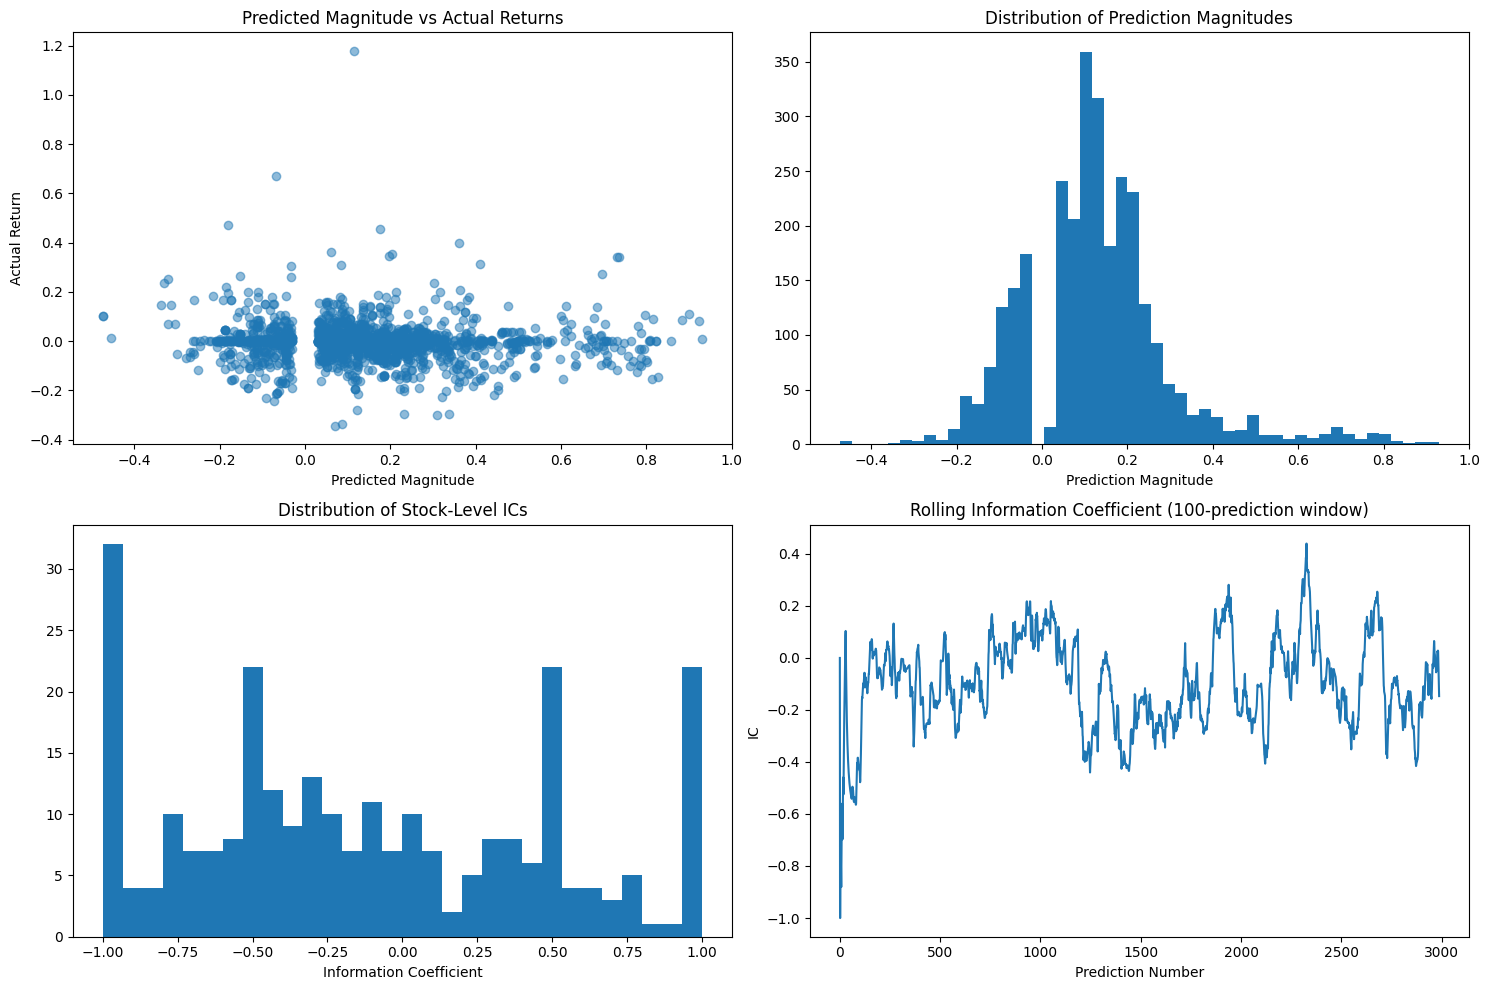


Consolidation Prediction Results:
--------------------------------------------------
Total predictions: 2988
Overall Information Coefficient: -0.082

IC Decay by Forward Period:
Period 1: -0.076
Period 2: -0.059
Period 3: -0.030
Period 4: 0.001
Period 5: 0.005
Period 6: -0.002
Period 7: 0.001
Period 8: 0.006
Period 9: 0.022
Period 10: 0.023


In [21]:
import pandas as pd
import numpy as np
from scipy import stats, signal
import glob
import os
from typing import Tuple, Dict, List
from tqdm import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
import warnings
from scipy.stats import gaussian_kde, spearmanr
import math
warnings.filterwarnings('ignore')

@dataclass
class PredictionResult:
    date: pd.Timestamp
    predicted_magnitude: float
    actual_return: float
    entropy_change: float
    volatility_ratio: float
    price_trend: float
    forward_return: float

class EntropyConsolidationPredictor:
    def __init__(self, 
                 entropy_window: int = 20,
                 trend_window: int = 50,
                 entropy_change_threshold: float = -0.25,  # More stringent
                 vol_ratio_threshold: float = 0.5,         # More stringent
                 forward_period: int = 5,
                 min_trend_strength: float = 0.03):        # Higher trend requirement
        
        self.entropy_window = entropy_window
        self.trend_window = trend_window
        self.entropy_change_threshold = entropy_change_threshold
        self.vol_ratio_threshold = vol_ratio_threshold
        self.forward_period = forward_period
        self.min_trend_strength = min_trend_strength

    def calculate_entropy(self, data: np.array, bins: int = 100) -> float:
        hist, _ = np.histogram(data, bins=bins)
        hist = hist[hist > 0]
        probs = hist / hist.sum()
        return -np.sum(probs * np.log2(probs))
    
    def calculate_prediction_magnitude(self, price_trend: float, entropy_change: float, vol_ratio: float) -> float:
            """Calculate prediction magnitude focusing on mid-range signals only."""
            # Scale entropy more aggressively for extreme values
            entropy_change = np.clip(entropy_change, -1, 1)
            entropy_severity = float(np.where(
                entropy_change < self.entropy_change_threshold,
                np.exp(-2 * abs(entropy_change)),  # Exponential scaling for severe drops
                0  # Zero out weak signals
            ))

            # More selective volatility component
            vol_severity = float(np.where(
                vol_ratio < self.vol_ratio_threshold,
                np.exp(-3 * vol_ratio),  # Stronger decay for higher volatility
                0
            ))

            # Trend with momentum consideration
            trend_magnitude = abs(price_trend)
            trend_sign = np.sign(price_trend)
            trend_component = float(np.where(
                trend_magnitude > self.min_trend_strength,
                trend_sign * np.power(trend_magnitude, 0.7),  # Power law scaling
                0
            ))

            # Combined signal with quality threshold
            raw_signal = (
                0.3 * entropy_severity +
                0.4 * vol_severity * trend_component +
                0.3 * trend_component
            )

            # Mid-range signal filtering:
            signal = float(np.clip(raw_signal, -1, 1))

            # Skip if signal is too weak or too strong
            if abs(signal) < 0.03 or abs(signal) > 0.95:
                return float('nan')  # Using float('nan') for consistent type

            # Scale remaining signals to use more of the range
            return float(signal * 1.001)




    def detect_consolidation(self, df: pd.DataFrame) -> List[PredictionResult]:
        predictions = []
        entropy_values = []
        
        # Add volatility ranking
        df['rolling_vol'] = df['returns'].rolling(self.trend_window).std()
        vol_rank = df['rolling_vol'].rolling(252).rank(pct=True)
        
        for i in range(self.entropy_window, len(df) - self.forward_period):
            if vol_rank.iloc[i] > 0.7:  # Skip high volatility periods
                continue
            
            current_window = df['returns'].iloc[i - self.entropy_window:i]
            prev_window = df['returns'].iloc[i - 2 * self.entropy_window:i - self.entropy_window]
            
            current_entropy = self.calculate_entropy(current_window)
            prev_entropy = self.calculate_entropy(prev_window)
            entropy_values.append(current_entropy)
            
            if len(entropy_values) < 2:
                continue
            
            entropy_change = (current_entropy - prev_entropy) / prev_entropy
            current_vol = np.std(current_window)
            historical_vol = np.std(df['returns'].iloc[max(0, i - self.trend_window):i])
            vol_ratio = current_vol / historical_vol if historical_vol != 0 else 1
            price_trend = (df['Close'].iloc[i] / df['Close'].iloc[i - self.trend_window] - 1)
            
            if (entropy_change < self.entropy_change_threshold and 
                vol_ratio < self.vol_ratio_threshold and
                abs(price_trend) > self.min_trend_strength):
                
                future_price = df['Close'].iloc[i + self.forward_period]
                current_price = df['Close'].iloc[i]
                forward_return = (future_price - current_price) / current_price
                
                predicted_magnitude = self.calculate_prediction_magnitude(
                    price_trend, entropy_change, vol_ratio
                )
                
                # Only add prediction if magnitude is not nan
                if not math.isnan(predicted_magnitude):
                    predictions.append(PredictionResult(
                        date=df.index[i],
                        predicted_magnitude=predicted_magnitude,
                        actual_return=forward_return,
                        entropy_change=entropy_change,
                        volatility_ratio=vol_ratio,
                        price_trend=price_trend,
                        forward_return=forward_return
                    ))
        
        return predictions
    


def analyze_consolidation_predictions(data_path: str = 'Data/PriceData'):
    filenumber = 5000
    #filenumber = 1000
    predictor = EntropyConsolidationPredictor()
    all_predictions = []
    stock_results = {}
    
    parquet_files = glob.glob(os.path.join(data_path, '*.parquet'))
    
    for file in tqdm(parquet_files[:filenumber]):
        try:
            symbol = os.path.basename(file).replace('.parquet', '')
            df = pd.read_parquet(file)
            df['returns'] = df['Close'].pct_change()
            df = df.dropna()
            
            if len(df) < 252:  # Minimum one year of data
                continue
            
            predictions = predictor.detect_consolidation(df)
            
            if predictions:
                all_predictions.extend(predictions)
                
                # Calculate IC for this stock
                pred_magnitudes = np.array([p.predicted_magnitude for p in predictions])
                actual_returns = np.array([p.actual_return for p in predictions])
                ic, _ = spearmanr(pred_magnitudes, actual_returns)
                
                stock_results[symbol] = {
                    'num_predictions': len(predictions),
                    'ic': ic,
                    'avg_entropy_change': np.mean([p.entropy_change for p in predictions]),
                    'avg_vol_ratio': np.mean([p.volatility_ratio for p in predictions])
                }
        
        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")
    
    predictions_df = pd.DataFrame([
        {
            'date': p.date,
            'predicted_magnitude': p.predicted_magnitude,
            'actual_return': p.actual_return,
            'entropy_change': p.entropy_change,
            'volatility_ratio': p.volatility_ratio,
            'price_trend': p.price_trend,
            'forward_return': p.forward_return
        } for p in all_predictions
    ])
    
    # Calculate rolling IC using a different approach
    window_size = min(100, len(predictions_df) // 4)
    rolling_ic = []
    
    for i in range(len(predictions_df)):
        start_idx = max(0, i - window_size + 1)
        window_pred = predictions_df['predicted_magnitude'].iloc[start_idx:i+1]
        window_actual = predictions_df['actual_return'].iloc[start_idx:i+1]
        
        if len(window_pred) >= 2:  # Need at least 2 points for correlation
            ic, _ = spearmanr(window_pred, window_actual)
            rolling_ic.append(ic if not np.isnan(ic) else 0)
        else:
            rolling_ic.append(0)
    
    # Convert rolling_ic to Series for plotting
    rolling_ic = pd.Series(rolling_ic, index=predictions_df.index)
    
    # Plotting
    plt.figure(figsize=(15, 10))
    
    plt.subplot(221)
    plt.scatter(predictions_df['predicted_magnitude'], 
               predictions_df['actual_return'], 
               alpha=0.5)
    plt.title('Predicted Magnitude vs Actual Returns')
    plt.xlabel('Predicted Magnitude')
    plt.ylabel('Actual Return')
    
    plt.subplot(222)
    plt.hist(predictions_df['predicted_magnitude'], bins=50)
    plt.title('Distribution of Prediction Magnitudes')
    plt.xlabel('Prediction Magnitude')
    
    plt.subplot(223)
    plt.hist([result['ic'] for result in stock_results.values()], bins=30)
    plt.title('Distribution of Stock-Level ICs')
    plt.xlabel('Information Coefficient')
    
    plt.subplot(224)
    plt.plot(rolling_ic)
    plt.title(f'Rolling Information Coefficient ({window_size}-prediction window)')
    plt.xlabel('Prediction Number')
    plt.ylabel('IC')
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print("\nConsolidation Prediction Results:")
    print("-" * 50)
    print(f"Total predictions: {len(predictions_df)}")
    
    overall_ic, _ = spearmanr(predictions_df['predicted_magnitude'], 
                             predictions_df['actual_return'])
    print(f"Overall Information Coefficient: {overall_ic:.3f}")
    
    # Calculate IC decay
    ic_decays = []
    for forward_period in range(1, 11):
        shifted_returns = predictions_df['actual_return'].shift(-forward_period)
        mask = ~shifted_returns.isna()  # Remove NaN values
        ic, _ = spearmanr(predictions_df.loc[mask, 'predicted_magnitude'], 
                         shifted_returns[mask])
        ic_decays.append(ic)
    
    print("\nIC Decay by Forward Period:")
    for period, ic in enumerate(ic_decays, 1):
        print(f"Period {period}: {ic:.3f}")
    
    return predictions_df, stock_results

if __name__ == "__main__":
    predictions_df, stock_results = analyze_consolidation_predictions()

In [ ]:
from dataclasses import dataclass
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
from scipy import stats
import os
import glob
from tqdm import tqdm
from itertools import product

@dataclass
class PredictionResult:
    date: pd.Timestamp
    predicted_direction: float
    actual_direction: float
    entropy_value: float
    entropy_percentile: float
    kl_divergence: float
    kl_percentile: float
    forward_return: float

class ExtremeEntropyPredictor:
    def __init__(self, 
                 short_window: int = 10,
                 long_window: int = 50,
                 percentile_threshold: int = 90,
                 forward_period: int = 5):
        
        self.short_window = short_window
        self.long_window = long_window
        self.percentile_threshold = percentile_threshold
        self.forward_period = forward_period
        
    def calculate_entropy(self, data: np.array, bins: int = 50) -> float:
        hist, _ = np.histogram(data, bins=bins)
        hist = hist[hist > 0]
        probs = hist / hist.sum()
        return -np.sum(probs * np.log2(probs))
    
    def calculate_relative_entropy(self, p: np.array, q: np.array) -> float:
        p = p + 1e-10
        q = q + 1e-10
        p = p / p.sum()
        q = q / q.sum()
        return np.sum(p * np.log2(p/q))
    
    def detect_extreme_patterns(self, df: pd.DataFrame) -> List[PredictionResult]:
        predictions = []
        returns = df['returns'].values
        
        short_entropies = []
        long_entropies = []
        kl_divs = []
        
        for i in range(max(self.short_window, self.long_window), len(returns)):
            short_window = returns[i-self.short_window:i]
            long_window = returns[i-self.long_window:i]
            
            short_entropy = self.calculate_entropy(short_window)
            long_entropy = self.calculate_entropy(long_window)
            
            hist_short, _ = np.histogram(short_window, bins=50)
            hist_long, _ = np.histogram(long_window, bins=50)
            kl_div = self.calculate_relative_entropy(hist_short, hist_long)
            
            short_entropies.append(short_entropy)
            long_entropies.append(long_entropy)
            kl_divs.append(kl_div)
        
        short_entropies = np.array(short_entropies)
        long_entropies = np.array(long_entropies)
        kl_divs = np.array(kl_divs)
        
        window_size = 100
        for i in range(window_size, len(short_entropies) - self.forward_period):
            window_slice = slice(max(0, i-window_size), i)
            
            short_percentile = stats.percentileofscore(
                short_entropies[window_slice], 
                short_entropies[i]
            )
            kl_percentile = stats.percentileofscore(
                kl_divs[window_slice],
                kl_divs[i]
            )
            
            # Record all patterns for later analysis
            current_idx = i + max(self.short_window, self.long_window)
            future_price = df['Close'].iloc[current_idx + self.forward_period]
            current_price = df['Close'].iloc[current_idx]
            forward_return = (future_price - current_price) / current_price
            
            # Store prediction regardless of thresholds
            predicted_direction = -np.sign(returns[current_idx]) if short_percentile > 50 else np.sign(returns[current_idx])
            actual_direction = np.sign(forward_return)
            
            predictions.append(PredictionResult(
                date=df.index[current_idx],
                predicted_direction=predicted_direction,
                actual_direction=actual_direction,
                entropy_value=short_entropies[i],
                entropy_percentile=short_percentile,
                kl_divergence=kl_divs[i],
                kl_percentile=kl_percentile,
                forward_return=forward_return
            ))
        
        return predictions
    
def analyze_threshold_combinations(predictions_df: pd.DataFrame) -> pd.DataFrame:
    """Analyze different combinations of entropy and KL divergence thresholds with stricter criteria"""
    # Keep the same thresholds since they found good IC values
    entropy_thresholds = range(1, 6, 1)
    kl_thresholds = range(85, 100, 1)
    
    results = []
    
    for entropy_threshold, kl_threshold in product(entropy_thresholds, kl_thresholds):
        for entropy_type in ['low', 'high']:
            mask = (predictions_df['entropy_percentile'] <= entropy_threshold) if entropy_type == 'low' \
                else (predictions_df['entropy_percentile'] >= (100 - entropy_threshold))
            mask = mask & (predictions_df['kl_percentile'] >= kl_threshold)
            
            subset = predictions_df[mask]
            
            if len(subset) >= 100:  # Keep minimum sample size requirement
                accuracy = (subset['predicted_direction'] == subset['actual_direction']).mean()
                ic = stats.spearmanr(subset['predicted_direction'], subset['forward_return'])[0]
                
                daily_returns = subset['forward_return'].values
                sharpe = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252) if len(daily_returns) > 0 else 0
                win_rate = np.mean(daily_returns > 0) if len(daily_returns) > 0 else 0
                
                results.append({
                    'entropy_type': entropy_type,
                    'entropy_threshold': entropy_threshold,
                    'kl_threshold': kl_threshold,
                    'accuracy': accuracy,
                    'ic': ic,
                    'abs_ic': abs(ic),
                    'count': len(subset),
                    'avg_return': subset['forward_return'].mean(),
                    'return_std': subset['forward_return'].std(),
                    't_stat': (subset['forward_return'].mean() / 
                             (subset['forward_return'].std() / np.sqrt(len(subset)))) if len(subset) > 0 else 0,
                    'sharpe': sharpe,
                    'win_rate': win_rate,
                    'avg_win': subset[subset['forward_return'] > 0]['forward_return'].mean() if len(subset) > 0 else 0,
                    'avg_loss': subset[subset['forward_return'] < 0]['forward_return'].mean() if len(subset) > 0 else 0,
                })
    
    return pd.DataFrame(results)

def plot_results(results_df: pd.DataFrame, entropy_type: str):
    """Plot analysis results with error handling"""
    try:
        import seaborn as sns
        import matplotlib.pyplot as plt
        
        subset = results_df[results_df['entropy_type'] == entropy_type]
        if len(subset) == 0:
            print(f"\nNo results to plot for {entropy_type} entropy")
            return
            
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        fig.suptitle(f'{entropy_type.capitalize()} Entropy Analysis Results', fontsize=16)
        
        # IC Values Heatmap
        pivot_data = subset.pivot(index='entropy_threshold', 
                                columns='kl_threshold', 
                                values='ic')
        sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='RdYlBu', center=0,
                   ax=axes[0,0])
        axes[0,0].set_title('Information Coefficient (IC)')
        
        # Sample Size Heatmap
        pivot_data = subset.pivot(index='entropy_threshold', 
                                columns='kl_threshold', 
                                values='count')
        sns.heatmap(pivot_data, annot=True, fmt=',d', cmap='YlOrRd',
                   ax=axes[0,1])
        axes[0,1].set_title('Sample Sizes')
        
        # Accuracy Heatmap
        pivot_data = subset.pivot(index='entropy_threshold', 
                                columns='kl_threshold', 
                                values='accuracy')
        sns.heatmap(pivot_data, annot=True, fmt='.2%', cmap='RdYlBu', center=0.5,
                   ax=axes[1,0])
        axes[1,0].set_title('Prediction Accuracy')
        
        # T-Statistic Heatmap
        pivot_data = subset.pivot(index='entropy_threshold', 
                                columns='kl_threshold', 
                                values='t_stat')
        sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlBu', center=0,
                   ax=axes[1,1])
        axes[1,1].set_title('T-Statistics')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"\nError in plotting: {str(e)}")

def analyze_extreme_patterns(data_path: str = 'Data/PriceData'):
    predictor = ExtremeEntropyPredictor(
        short_window=5,
        long_window=30,
        percentile_threshold=95,
        forward_period=5
    )
    all_predictions = []
    
    parquet_files = glob.glob(os.path.join(data_path, '*.parquet'))
    
    ##just use 500 files not all of them 
    #parquet_files = parquet_files[:500]


    for file in tqdm(parquet_files):
        try:
            symbol = os.path.basename(file).replace('.parquet', '')
            df = pd.read_parquet(file)
            df['returns'] = df['Close'].pct_change()
            df = df.dropna()
            
            if len(df) < 252:
                continue
                
            predictions = predictor.detect_extreme_patterns(df)
            if predictions:
                all_predictions.extend(predictions)
                
        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")
            continue
    
    if not all_predictions:
        print("\nNo valid predictions were generated.")
        return None, None
    
    predictions_df = pd.DataFrame([vars(p) for p in all_predictions])
    results_df = analyze_threshold_combinations(predictions_df)
    
    print("\nDetailed Analysis of Extreme Patterns")
    print("-" * 50)
    print("Total predictions analyzed:", len(predictions_df))
    
    # Analyze results for each entropy type
    for entropy_type in ['low', 'high']:
        subset = results_df[results_df['entropy_type'] == entropy_type]
        
        if len(subset) == 0:
            print(f"\n{entropy_type.upper()} ENTROPY: No results found matching criteria")
            continue
            
        print(f"\n{entropy_type.upper()} ENTROPY RESULTS (Top 10 by absolute IC):")
        top_results = subset.nlargest(10, 'abs_ic')
        display_cols = ['entropy_threshold', 'kl_threshold', 'accuracy', 'ic', 
                       'count', 't_stat', 'sharpe', 'win_rate']
        print(top_results[display_cols].round(4).to_string())
        
        if len(top_results) > 0:
            best_result = top_results.iloc[0]
            print(f"\nBest {entropy_type} entropy configuration (by |IC|):")
            print(f"Entropy threshold: {best_result['entropy_threshold']}")
            print(f"KL threshold: {best_result['kl_threshold']}")
            print(f"Accuracy: {best_result['accuracy']:.2%}")
            print(f"IC: {best_result['ic']:.4f}")
            print(f"Sample size: {best_result['count']:,}")
            print(f"T-statistic: {best_result['t_stat']:.4f}")
            print(f"Sharpe ratio: {best_result['sharpe']:.4f}")
            print(f"Win rate: {best_result['win_rate']:.2%}")
            print(f"Avg win: {best_result['avg_win']:.2%}")
            print(f"Avg loss: {best_result['avg_loss']:.2%}")
            
        # Plot results
        plot_results(results_df, entropy_type)
    
    return predictions_df, results_df

if __name__ == "__main__":
    predictions_df, results_df = analyze_extreme_patterns()
    
    if results_df is not None and len(results_df) > 0:
        results_df.to_csv('entropy_threshold_results_extreme.csv')
        print("\nResults saved to 'entropy_threshold_results_extreme.csv'")
    else:
        print("\nNo results were generated to save.")

100%|██████████| 100/100 [00:09<00:00, 10.92it/s]



Enhanced RSI Analysis Results
----------------------------------------

Overall Super RSI IC: -0.0186 (abs: 0.0186)

IC by Volatility Regime:
Volatility Quartile 1: IC = 0.0025
Volatility Quartile 2: IC = -0.0167
Volatility Quartile 3: IC = -0.0290
Volatility Quartile 4: IC = -0.0248

Top 5 Individual RSI Periods by |IC|:
   period        ic    abs_ic
1       3 -0.016994  0.016994
2       5 -0.016471  0.016471
0       2 -0.016011  0.016011
3       8 -0.014281  0.014281
4      13 -0.011701  0.011701


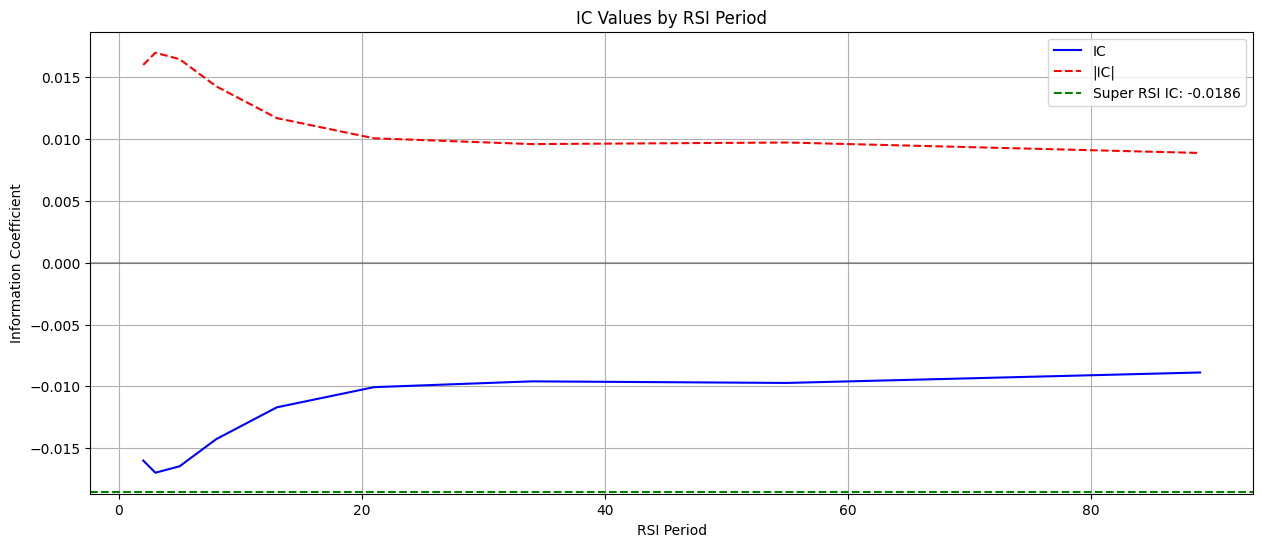

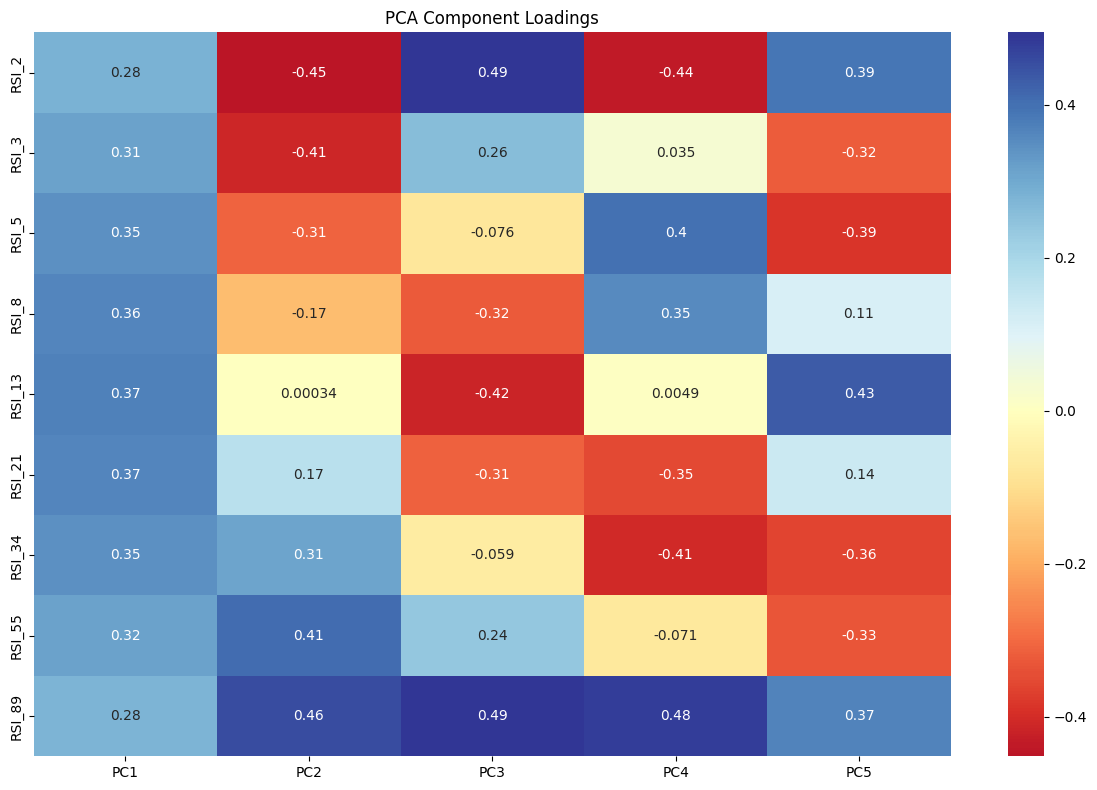


Super RSI Statistics:
Mean: 51.89
Std: 18.55
Min: 0.00
Max: 100.00


In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from dataclasses import dataclass
from tqdm import tqdm
import warnings
import glob
import os
from scipy import stats
warnings.filterwarnings('ignore')

@dataclass
class RSIPCAResults:
    """Store results from RSI PCA analysis"""
    symbol: str
    date: pd.Timestamp
    rsi_values: Dict[int, float]
    pca_components: List[float]
    explained_variance_ratios: List[float]
    super_rsi: float
    next_return: float
    volatility: float

class MultiPeriodRSIAnalyzer:
    def __init__(self):
        """Initialize RSI analyzer with Fibonacci-based periods"""
        self.short_periods = [2, 3, 5, 8, 13, 21]  # Fibonacci sequence
        self.long_periods = [34, 55, 89]  # Continue Fibonacci
        self.all_periods = self.short_periods + self.long_periods
        self.n_components = 5
        self.pca = PCA(n_components=self.n_components)
        self.scaler = StandardScaler()
        self.volatility_window = 20
        
    def calculate_rsi(self, data: pd.Series, period: int) -> pd.Series:
        """Calculate RSI with exponential smoothing"""
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).ewm(span=period).mean()
        loss = (-delta.where(delta < 0, 0)).ewm(span=period).mean()
        
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    def analyze_single_stock(self, df: pd.DataFrame, symbol: str) -> List[RSIPCAResults]:
        """Analyze single stock with enhanced features"""
        results = []
        
        # Calculate returns and volatility
        df['next_return'] = df['Close'].pct_change().shift(-1)
        df['volatility'] = df['Close'].pct_change().rolling(self.volatility_window).std()
        
        # Calculate RSI for all periods
        rsi_data = pd.DataFrame()
        for period in self.all_periods:
            rsi_data[f'RSI_{period}'] = self.calculate_rsi(df['Close'], period)
        
        rsi_data = rsi_data.dropna()
        if len(rsi_data) == 0:
            return results
        
        # Apply PCA with weighted components
        scaled_data = self.scaler.fit_transform(rsi_data)
        pca_result = self.pca.fit_transform(scaled_data)
        
        # Create weighted super RSI
        weights = self.pca.explained_variance_ratio_
        weighted_components = np.sum(pca_result * weights.reshape(1, -1), axis=1)
        super_rsi = (weighted_components - weighted_components.min()) / \
                   (weighted_components.max() - weighted_components.min()) * 100
        
        # Store results
        valid_indices = rsi_data.index
        for i in range(len(rsi_data)):
            idx = valid_indices[i]
            rsi_values = {period: rsi_data.iloc[i][f'RSI_{period}'] 
                         for period in self.all_periods}
            
            results.append(RSIPCAResults(
                symbol=symbol,
                date=df.index[idx],
                rsi_values=rsi_values,
                pca_components=pca_result[i, :].tolist(),
                explained_variance_ratios=self.pca.explained_variance_ratio_.tolist(),
                super_rsi=super_rsi[i],
                next_return=df['next_return'].iloc[idx],
                volatility=df['volatility'].iloc[idx]
            ))
        
        return results

def analyze_rsi_patterns(data_path: str = 'Data/PriceData'):
    """Analyze RSI patterns across multiple stocks"""
    analyzer = MultiPeriodRSIAnalyzer()
    all_results = []
    stock_results = {}
    
    parquet_files = glob.glob(os.path.join(data_path, '*.parquet'))
    parquet_files = parquet_files[:100]  # Use first 100 files for testing
    
    for file in tqdm(parquet_files):
        try:
            symbol = os.path.basename(file).replace('.parquet', '')
            df = pd.read_parquet(file)
            
            if len(df) < 252:  # Minimum one year of data
                continue
            
            stock_result = analyzer.analyze_single_stock(df, symbol)
            if stock_result:
                all_results.extend(stock_result)
                stock_results[symbol] = stock_result
                
        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")
            continue
    
    return analyze_results(all_results, stock_results, analyzer)

def analyze_results(all_results: List[RSIPCAResults], 
                   stock_results: Dict[str, List[RSIPCAResults]],
                   analyzer: MultiPeriodRSIAnalyzer):
    """Enhanced analysis with volatility regimes"""
    
    results_df = pd.DataFrame([{
        'symbol': r.symbol,
        'date': r.date,
        'super_rsi': r.super_rsi,
        'next_return': r.next_return,
        'volatility': r.volatility,
        **{f'RSI_{p}': r.rsi_values[p] for p in analyzer.all_periods}
    } for r in all_results])
    
    results_df = results_df.dropna()
    
    print("\nEnhanced RSI Analysis Results")
    print("-" * 40)
    
    # Overall IC for super RSI
    super_rsi_ic = stats.spearmanr(results_df['super_rsi'].values, 
                                  results_df['next_return'].values)[0]
    print(f"\nOverall Super RSI IC: {super_rsi_ic:.4f} (abs: {abs(super_rsi_ic):.4f})")
    
    # IC by volatility regime
    vol_quantiles = results_df['volatility'].quantile([0.25, 0.5, 0.75])
    print("\nIC by Volatility Regime:")
    for i, (lower, upper) in enumerate(zip([0, vol_quantiles[0.25], vol_quantiles[0.5], vol_quantiles[0.75]], 
                                         [vol_quantiles[0.25], vol_quantiles[0.5], vol_quantiles[0.75], float('inf')])):
        mask = (results_df['volatility'] > lower) & (results_df['volatility'] <= upper)
        regime_ic = stats.spearmanr(results_df.loc[mask, 'super_rsi'].values,
                                   results_df.loc[mask, 'next_return'].values)[0]
        print(f"Volatility Quartile {i+1}: IC = {regime_ic:.4f}")
    
    # IC for individual RSI periods
    ic_results = []
    for period in analyzer.all_periods:
        column = f'RSI_{period}'
        ic = stats.spearmanr(results_df[column].values, 
                            results_df['next_return'].values)[0]
        ic_results.append({
            'period': period,
            'ic': ic,
            'abs_ic': abs(ic)
        })
    
    ic_df = pd.DataFrame(ic_results)
    print("\nTop 5 Individual RSI Periods by |IC|:")
    print(ic_df.nlargest(5, 'abs_ic')[['period', 'ic', 'abs_ic']].to_string())
    
    # Plot IC values
    plt.figure(figsize=(15, 6))
    plt.plot(ic_df['period'], ic_df['ic'], 'b-', label='IC')
    plt.plot(ic_df['period'], ic_df['abs_ic'], 'r--', label='|IC|')
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axhline(y=super_rsi_ic, color='g', linestyle='--', 
                label=f'Super RSI IC: {super_rsi_ic:.4f}')
    plt.title('IC Values by RSI Period')
    plt.xlabel('RSI Period')
    plt.ylabel('Information Coefficient')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Component loadings
    loadings = pd.DataFrame(
        analyzer.pca.components_.T,
        columns=[f'PC{i+1}' for i in range(analyzer.n_components)],
        index=[f'RSI_{p}' for p in analyzer.all_periods]
    )
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(loadings, cmap='RdYlBu', center=0, annot=True)
    plt.title('PCA Component Loadings')
    plt.tight_layout()
    plt.show()
    
    # Basic stats
    print("\nSuper RSI Statistics:")
    print(f"Mean: {results_df['super_rsi'].mean():.2f}")
    print(f"Std: {results_df['super_rsi'].std():.2f}")
    print(f"Min: {results_df['super_rsi'].min():.2f}")
    print(f"Max: {results_df['super_rsi'].max():.2f}")
    
    return results_df, ic_df

if __name__ == "__main__":
    results_df, ic_df = analyze_rsi_patterns()

100%|██████████| 100/100 [00:09<00:00, 10.70it/s]



Enhanced Contrarian RSI Analysis Results
----------------------------------------

Overall Super RSI IC: 0.0190 (abs: 0.0190)
Directional Accuracy: 0.5106

IC by Volatility Regime:
Volatility Quartile 1: IC = -0.0023, Accuracy = 0.5066
Volatility Quartile 2: IC = 0.0193, Accuracy = 0.5086
Volatility Quartile 3: IC = 0.0270, Accuracy = 0.5148
Volatility Quartile 4: IC = 0.0247, Accuracy = 0.5122

Top 5 Individual RSI Periods by |IC|:
   period        ic    abs_ic
1       3  0.015722  0.015722
2       5  0.015232  0.015232
0       2  0.014821  0.014821
3       8  0.013232  0.013232
4      13  0.010853  0.010853


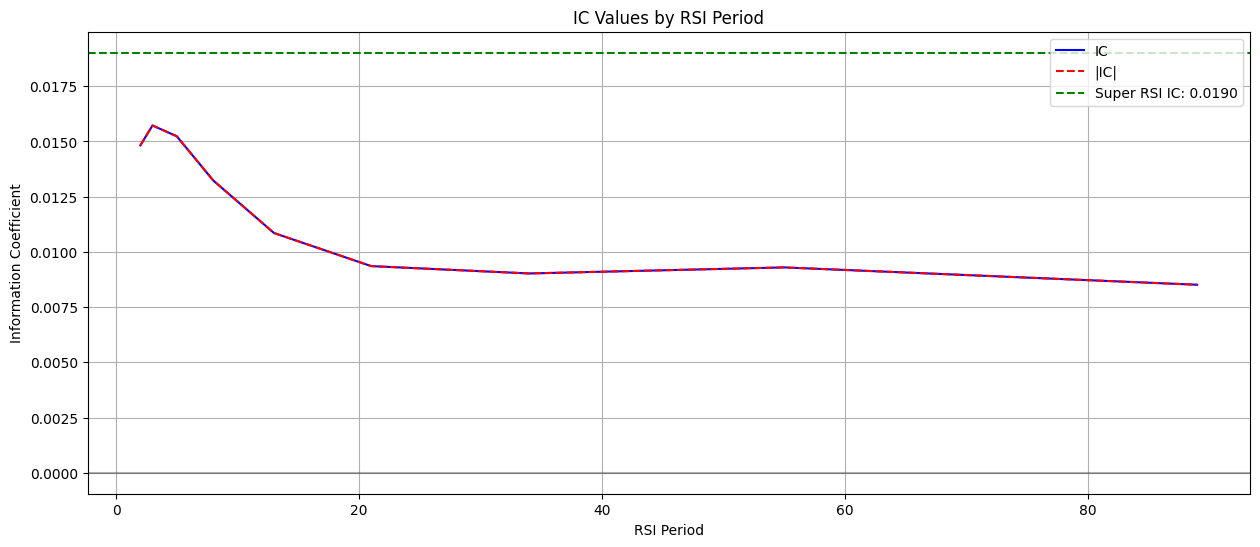

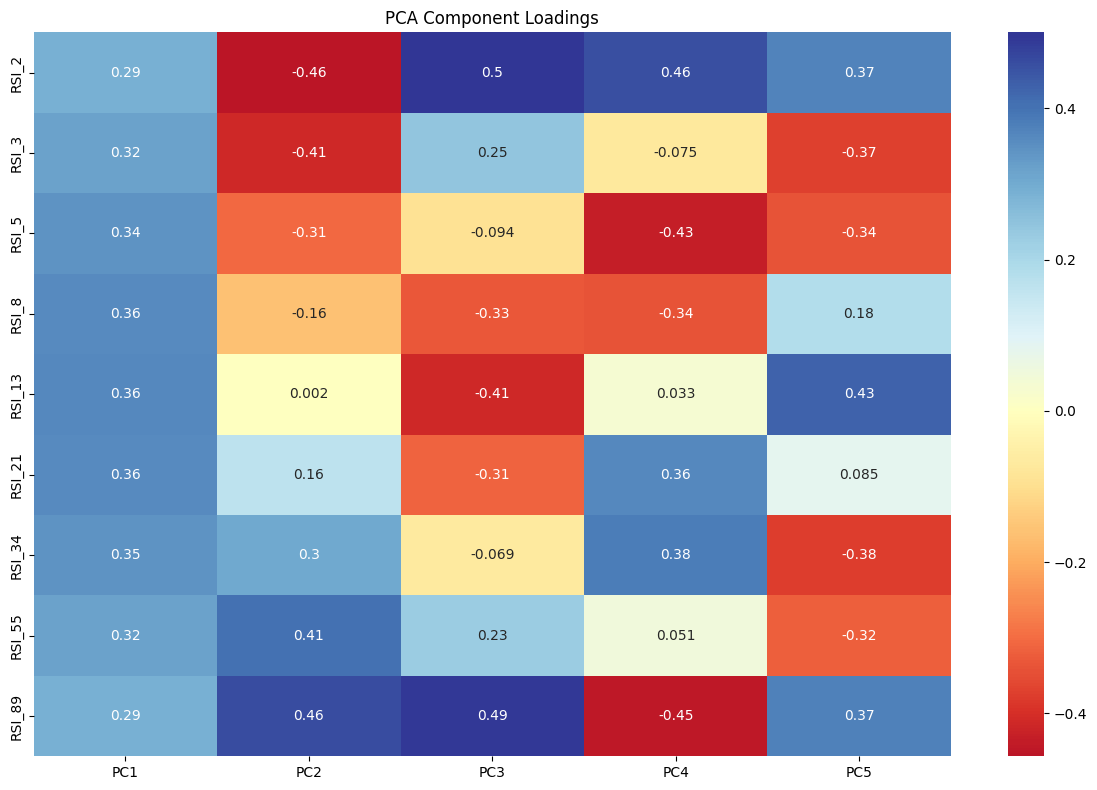


Super RSI Statistics:
Mean: 48.01
Std: 18.51
Min: 0.00
Max: 100.00


In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from dataclasses import dataclass
from tqdm import tqdm
import warnings
import glob
import os
from scipy import stats
warnings.filterwarnings('ignore')

@dataclass
class RSIPCAResults:
    """Store results from RSI PCA analysis"""
    symbol: str
    date: pd.Timestamp
    rsi_values: Dict[int, float]
    pca_components: List[float]
    explained_variance_ratios: List[float]
    super_rsi: float
    next_return: float
    volatility: float

class MultiPeriodRSIAnalyzer:
    def __init__(self):
        """Initialize RSI analyzer with Fibonacci-based periods"""
        self.short_periods = [2, 3, 5, 8, 13, 21]  # Fibonacci sequence
        self.long_periods = [34, 55, 89]  # Continue Fibonacci
        self.all_periods = self.short_periods + self.long_periods
        self.n_components = 5
        self.pca = PCA(n_components=self.n_components)
        self.scaler = StandardScaler()
        self.volatility_window = 20
        
    def calculate_rsi(self, data: pd.Series, period: int) -> pd.Series:
        """Calculate RSI with exponential smoothing"""
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).ewm(span=period).mean()
        loss = (-delta.where(delta < 0, 0)).ewm(span=period).mean()
        
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    def analyze_single_stock(self, df: pd.DataFrame, symbol: str) -> List[RSIPCAResults]:
        """Analyze single stock with enhanced features"""
        results = []
        
        # Calculate returns and volatility
        df['next_return'] = df['Close'].pct_change().shift(-1)
        df['volatility'] = df['Close'].pct_change().rolling(self.volatility_window).std()
        
        # Calculate RSI for all periods
        rsi_data = pd.DataFrame()
        for period in self.all_periods:
            rsi_data[f'RSI_{period}'] = self.calculate_rsi(df['Close'], period)
            # Invert RSI to make it contrarian (100 - RSI)
            rsi_data[f'RSI_{period}'] = 100 - rsi_data[f'RSI_{period}']
        
        rsi_data = rsi_data.dropna()
        if len(rsi_data) == 0:
            return results
        
        # Apply PCA with weighted components
        scaled_data = self.scaler.fit_transform(rsi_data)
        pca_result = self.pca.fit_transform(scaled_data)
        
        # Create weighted super RSI (now contrarian)
        weights = self.pca.explained_variance_ratio_
        weighted_components = np.sum(pca_result * weights.reshape(1, -1), axis=1)
        super_rsi = (weighted_components - weighted_components.min()) / \
                   (weighted_components.max() - weighted_components.min()) * 100
        
        # Store results
        valid_indices = rsi_data.index
        for i in range(len(rsi_data)):
            idx = valid_indices[i]
            rsi_values = {period: rsi_data.iloc[i][f'RSI_{period}'] 
                         for period in self.all_periods}
            
            results.append(RSIPCAResults(
                symbol=symbol,
                date=df.index[idx],
                rsi_values=rsi_values,
                pca_components=pca_result[i, :].tolist(),
                explained_variance_ratios=self.pca.explained_variance_ratio_.tolist(),
                super_rsi=super_rsi[i],
                next_return=df['next_return'].iloc[idx],
                volatility=df['volatility'].iloc[idx]
            ))
        
        return results

def analyze_rsi_patterns(data_path: str = 'Data/PriceData'):
    """Analyze RSI patterns across multiple stocks"""
    analyzer = MultiPeriodRSIAnalyzer()
    all_results = []
    stock_results = {}
    
    parquet_files = glob.glob(os.path.join(data_path, '*.parquet'))
    parquet_files = parquet_files[:100]  # Use first 100 files for testing
    
    for file in tqdm(parquet_files):
        try:
            symbol = os.path.basename(file).replace('.parquet', '')
            df = pd.read_parquet(file)
            
            if len(df) < 252:  # Minimum one year of data
                continue
            
            stock_result = analyzer.analyze_single_stock(df, symbol)
            if stock_result:
                all_results.extend(stock_result)
                stock_results[symbol] = stock_result
                
        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")
            continue
    
    return analyze_results(all_results, stock_results, analyzer)

def analyze_results(all_results: List[RSIPCAResults], 
                   stock_results: Dict[str, List[RSIPCAResults]],
                   analyzer: MultiPeriodRSIAnalyzer):
    """Enhanced analysis with volatility regimes"""
    
    results_df = pd.DataFrame([{
        'symbol': r.symbol,
        'date': r.date,
        'super_rsi': r.super_rsi,
        'next_return': r.next_return,
        'volatility': r.volatility,
        **{f'RSI_{p}': r.rsi_values[p] for p in analyzer.all_periods}
    } for r in all_results])
    
    results_df = results_df.dropna()
    
    print("\nEnhanced Contrarian RSI Analysis Results")
    print("-" * 40)
    
    # Overall IC for super RSI
    super_rsi_ic = stats.spearmanr(results_df['super_rsi'].values, 
                                  results_df['next_return'].values)[0]
    print(f"\nOverall Super RSI IC: {super_rsi_ic:.4f} (abs: {abs(super_rsi_ic):.4f})")
    
    # Add directional accuracy
    results_df['signal'] = (results_df['super_rsi'] > 50).astype(int)  # 1 for buy (RSI < 50), 0 for sell (RSI > 50)
    results_df['correct'] = (results_df['signal'] == (results_df['next_return'] > 0)).astype(int)
    accuracy = results_df['correct'].mean()
    print(f"Directional Accuracy: {accuracy:.4f}")
    
    # IC by volatility regime
    vol_quantiles = results_df['volatility'].quantile([0.25, 0.5, 0.75])
    print("\nIC by Volatility Regime:")
    for i, (lower, upper) in enumerate(zip([0, vol_quantiles[0.25], vol_quantiles[0.5], vol_quantiles[0.75]], 
                                         [vol_quantiles[0.25], vol_quantiles[0.5], vol_quantiles[0.75], float('inf')])):
        mask = (results_df['volatility'] > lower) & (results_df['volatility'] <= upper)
        regime_ic = stats.spearmanr(results_df.loc[mask, 'super_rsi'].values,
                                   results_df.loc[mask, 'next_return'].values)[0]
        regime_accuracy = results_df.loc[mask, 'correct'].mean()
        print(f"Volatility Quartile {i+1}: IC = {regime_ic:.4f}, Accuracy = {regime_accuracy:.4f}")
    
    # IC for individual RSI periods
    ic_results = []
    for period in analyzer.all_periods:
        column = f'RSI_{period}'
        ic = stats.spearmanr(results_df[column].values, 
                            results_df['next_return'].values)[0]
        ic_results.append({
            'period': period,
            'ic': ic,
            'abs_ic': abs(ic)
        })
    
    ic_df = pd.DataFrame(ic_results)
    print("\nTop 5 Individual RSI Periods by |IC|:")
    print(ic_df.nlargest(5, 'abs_ic')[['period', 'ic', 'abs_ic']].to_string())
    
    # Plot IC values
    plt.figure(figsize=(15, 6))
    plt.plot(ic_df['period'], ic_df['ic'], 'b-', label='IC')
    plt.plot(ic_df['period'], ic_df['abs_ic'], 'r--', label='|IC|')
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axhline(y=super_rsi_ic, color='g', linestyle='--', 
                label=f'Super RSI IC: {super_rsi_ic:.4f}')
    plt.title('IC Values by RSI Period')
    plt.xlabel('RSI Period')
    plt.ylabel('Information Coefficient')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Component loadings
    loadings = pd.DataFrame(
        analyzer.pca.components_.T,
        columns=[f'PC{i+1}' for i in range(analyzer.n_components)],
        index=[f'RSI_{p}' for p in analyzer.all_periods]
    )
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(loadings, cmap='RdYlBu', center=0, annot=True)
    plt.title('PCA Component Loadings')
    plt.tight_layout()
    plt.show()
    
    # Basic stats
    print("\nSuper RSI Statistics:")
    print(f"Mean: {results_df['super_rsi'].mean():.2f}")
    print(f"Std: {results_df['super_rsi'].std():.2f}")
    print(f"Min: {results_df['super_rsi'].min():.2f}")
    print(f"Max: {results_df['super_rsi'].max():.2f}")
    
    return results_df, ic_df

if __name__ == "__main__":
    results_df, ic_df = analyze_rsi_patterns()

In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from dataclasses import dataclass
from tqdm import tqdm
import warnings
import glob
import os
from scipy import stats
warnings.filterwarnings('ignore')

@dataclass
class RSIPCAResults:
    """Store results from RSI PCA analysis"""
    symbol: str
    date: pd.Timestamp
    rsi_values: Dict[int, float]
    pca_components: List[float]
    explained_variance_ratios: List[float]
    super_rsi: float
    next_return: float
    volatility: float
    atr_ratio: float  # Added ATR ratio
    volume_surge: float  # Added volume surge

class MultiPeriodRSIAnalyzer:
    def __init__(self):
        self.short_periods = [2, 3, 5, 8, 13, 21]
        self.long_periods = [34, 55, 89]
        self.all_periods = self.short_periods + self.long_periods
        self.n_components = 5
        self.pca = PCA(n_components=self.n_components)
        self.scaler = StandardScaler()
        self.volatility_window = 20
        self.volume_window = 20
        self.atr_period = 14
        self.min_volatility_percentile = 75  # Only consider top quartile volatility
        self.extreme_rsi_percentile = 25  # Only generate signals for extreme RSI values
        
    def calculate_atr(self, df: pd.DataFrame) -> pd.Series:
        """Calculate Average True Range"""
        high = df['High']
        low = df['Low']
        close = df['Close']
        
        tr1 = high - low
        tr2 = abs(high - close.shift())
        tr3 = abs(low - close.shift())
        
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        return tr.rolling(self.atr_period).mean()
        
    def calculate_rsi(self, data: pd.Series, period: int) -> pd.Series:
        """Calculate RSI with exponential smoothing"""
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).ewm(span=period).mean()
        loss = (-delta.where(delta < 0, 0)).ewm(span=period).mean()
        
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    def analyze_single_stock(self, df: pd.DataFrame, symbol: str) -> List[RSIPCAResults]:
        results = []
        
        # Calculate returns and volatility
        df['next_return'] = df['Close'].pct_change().shift(-1)
        df['volatility'] = df['Close'].pct_change().rolling(self.volatility_window).std()
        
        # Calculate ATR ratio (ATR relative to price)
        df['atr'] = self.calculate_atr(df)
        df['atr_ratio'] = df['atr'] / df['Close']
        
        # Calculate volume surge (volume relative to moving average)
        df['volume_ma'] = df['Volume'].rolling(self.volume_window).mean()
        df['volume_surge'] = df['Volume'] / df['volume_ma']
        
        # Calculate RSI for all periods
        rsi_data = pd.DataFrame()
        for period in self.all_periods:
            rsi_data[f'RSI_{period}'] = self.calculate_rsi(df['Close'], period)
            rsi_data[f'RSI_{period}'] = 100 - rsi_data[f'RSI_{period}']  # Invert RSI
        
        rsi_data = rsi_data.dropna()
        if len(rsi_data) == 0:
            return results
            
        # Get volatility threshold
        vol_threshold = df['volatility'].quantile(self.min_volatility_percentile/100)
        
        # Apply PCA with weighted components
        scaled_data = self.scaler.fit_transform(rsi_data)
        pca_result = self.pca.fit_transform(scaled_data)
        
        weights = self.pca.explained_variance_ratio_
        weighted_components = np.sum(pca_result * weights.reshape(1, -1), axis=1)
        super_rsi = (weighted_components - weighted_components.min()) / \
                   (weighted_components.max() - weighted_components.min()) * 100
        
        valid_indices = rsi_data.index
        for i in range(len(rsi_data)):
            idx = valid_indices[i]
            
            # Only include high volatility periods
            if df['volatility'].iloc[idx] < vol_threshold:
                continue
                
            rsi_values = {period: rsi_data.iloc[i][f'RSI_{period}'] 
                         for period in self.all_periods}
            
            results.append(RSIPCAResults(
                symbol=symbol,
                date=df.index[idx],
                rsi_values=rsi_values,
                pca_components=pca_result[i, :].tolist(),
                explained_variance_ratios=self.pca.explained_variance_ratio_.tolist(),
                super_rsi=super_rsi[i],
                next_return=df['next_return'].iloc[idx],
                volatility=df['volatility'].iloc[idx],
                atr_ratio=df['atr_ratio'].iloc[idx],
                volume_surge=df['volume_surge'].iloc[idx]
            ))
        
        return results

def analyze_results(all_results: List[RSIPCAResults], 
                   stock_results: Dict[str, List[RSIPCAResults]],
                   analyzer: MultiPeriodRSIAnalyzer):
    
    results_df = pd.DataFrame([{
        'symbol': r.symbol,
        'date': r.date,
        'super_rsi': r.super_rsi,
        'next_return': r.next_return,
        'volatility': r.volatility,
        'atr_ratio': r.atr_ratio,
        'volume_surge': r.volume_surge,
        **{f'RSI_{p}': r.rsi_values[p] for p in analyzer.all_periods}
    } for r in all_results])
    
    results_df = results_df.dropna()
    
    print("\nEnhanced High-Volatility RSI Analysis Results")
    print("-" * 50)
    
    # Generate signals only for extreme RSI values
    extreme_high = results_df['super_rsi'].quantile(1 - analyzer.extreme_rsi_percentile/100)
    extreme_low = results_df['super_rsi'].quantile(analyzer.extreme_rsi_percentile/100)
    
    # Create mask for extreme values
    extreme_mask = (results_df['super_rsi'] >= extreme_high) | (results_df['super_rsi'] <= extreme_low)
    extreme_df = results_df[extreme_mask].copy()
    
    # Calculate metrics for extreme values only
    extreme_df['signal'] = (extreme_df['super_rsi'] > 50).astype(int)
    extreme_df['correct'] = (extreme_df['signal'] == (extreme_df['next_return'] > 0)).astype(int)
    
    # Overall metrics for extreme values
    extreme_ic = stats.spearmanr(extreme_df['super_rsi'].values, 
                                extreme_df['next_return'].values)[0]
    extreme_accuracy = extreme_df['correct'].mean()
    
    print(f"\nMetrics for Extreme RSI Values (top/bottom {analyzer.extreme_rsi_percentile}%):")
    print(f"Signal Count: {len(extreme_df)}")
    print(f"IC: {extreme_ic:.4f}")
    print(f"Directional Accuracy: {extreme_accuracy:.4f}")
    
    # Additional analysis by volume surge
    print("\nAnalysis by Volume Surge:")
    vol_surge_threshold = extreme_df['volume_surge'].quantile(0.75)
    high_volume_mask = extreme_df['volume_surge'] > vol_surge_threshold
    
    high_vol_accuracy = extreme_df[high_volume_mask]['correct'].mean()
    print(f"Accuracy with High Volume Surge: {high_vol_accuracy:.4f}")
    
    # Analysis by ATR ratio
    print("\nAnalysis by ATR Ratio:")
    high_atr_mask = extreme_df['atr_ratio'] > extreme_df['atr_ratio'].quantile(0.75)
    high_atr_accuracy = extreme_df[high_atr_mask]['correct'].mean()
    print(f"Accuracy with High ATR Ratio: {high_atr_accuracy:.4f}")
    
    # Combined conditions
    combined_mask = high_volume_mask & high_atr_mask
    combined_accuracy = extreme_df[combined_mask]['correct'].mean()
    print(f"\nAccuracy with All Conditions: {combined_accuracy:.4f}")
    print(f"Number of Signals: {combined_mask.sum()}")
    
    return results_df, extreme_df[combined_mask]

def analyze_rsi_patterns(data_path: str = 'Data/PriceData'):
    analyzer = MultiPeriodRSIAnalyzer()
    all_results = []
    stock_results = {}
    
    parquet_files = glob.glob(os.path.join(data_path, '*.parquet'))
    parquet_files = parquet_files[:100]
    
    for file in tqdm(parquet_files):
        try:
            symbol = os.path.basename(file).replace('.parquet', '')
            df = pd.read_parquet(file)
            
            if len(df) < 252:
                continue
            
            stock_result = analyzer.analyze_single_stock(df, symbol)
            if stock_result:
                all_results.extend(stock_result)
                stock_results[symbol] = stock_result
                
        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")
            continue
    
    return analyze_results(all_results, stock_results, analyzer)

if __name__ == "__main__":
    results_df, filtered_results = analyze_rsi_patterns()

100%|██████████| 100/100 [00:03<00:00, 25.95it/s]



Enhanced High-Volatility RSI Analysis Results
--------------------------------------------------

Metrics for Extreme RSI Values (top/bottom 25%):
Signal Count: 8734
IC: 0.0387
Directional Accuracy: 0.5208

Analysis by Volume Surge:
Accuracy with High Volume Surge: 0.5412

Analysis by ATR Ratio:
Accuracy with High ATR Ratio: 0.5101

Accuracy with All Conditions: 0.5244
Number of Signals: 595


In [ ]:
import pandas as pd
import numpy as np
import multiprocessing
from tqdm import tqdm
import glob
import os
import matplotlib.pyplot as plt
from datetime import datetime

def calculate_features(returns: np.ndarray, window: int = 20) -> dict:
    """Extremely minimal feature calculation - just std and range"""
    rolled = pd.Series(returns).rolling(window).agg(['std', 'max', 'min']).values
    return {
        'std': rolled[:, 0],  # std
        'range': rolled[:, 1] - rolled[:, 2]  # max - min
    }

def process_single_file(file_path: str) -> tuple[str, pd.DataFrame]:
    """Minimal processing per file"""
    try:
        # Load only Close price
        df = pd.read_parquet(file_path, columns=['Close'])
        if len(df) < 252:
            return None
        
        # Calculate returns and features
        returns = df['Close'].pct_change().fillna(0).values
        features = calculate_features(returns)
        
        # Create minimal DataFrame with features
        feature_df = pd.DataFrame({
            'volatility': features['std'],
            'range': features['range']
        }, index=df.index[20:])  # Adjust index for window size
        
        symbol = os.path.basename(file_path).replace('.parquet', '')
        return symbol, feature_df
        
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def quick_plot(results: dict):
    """Simple matplotlib plot"""
    plt.figure(figsize=(15, 5))
    
    # Plot first 5 stocks' volatility
    for i, (symbol, df) in enumerate(list(results.items())[:5]):
        plt.plot(df['volatility'], label=symbol, alpha=0.7)
    
    plt.title('Volatility Over Time')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'volatility_plot_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png')
    plt.close()

if __name__ == "__main__":
    start_time = datetime.now()
    
    # Get file paths
    file_paths = glob.glob('Data/PriceData/*.parquet')
    
    # Process files in parallel
    with multiprocessing.Pool(16) as pool:
        results = list(tqdm(
            pool.imap(process_single_file, file_paths),
            total=len(file_paths),
            desc="Processing files"
        ))
    
    # Filter and convert to dict
    valid_results = {symbol: df 
                    for result in results 
                    if result is not None
                    for symbol, df in [result]}
    
    # Print processing statistics
    end_time = datetime.now()
    total_time = (end_time - start_time).total_seconds()
    files_processed = len(valid_results)
    
    print(f"\nProcessing Summary:")
    print(f"Files processed: {files_processed}")
    print(f"Total time: {total_time:.2f} seconds")
    print(f"Average time per file: {total_time/files_processed:.3f} seconds")
    
    # Create simple plot
    quick_plot(valid_results)

Processing files:   0%|          | 0/177 [00:00<?, ?it/s]

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from statsmodels.tsa.stattools import coint
from itertools import combinations
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib
import logging

# Configure logging
logging.basicConfig(filename='cointegration_errors.log', level=logging.ERROR, 
                    format='%(asctime)s:%(levelname)s:%(message)s')

# Function to load a single Parquet file and return the 'Adj Close' series
def load_adj_close(ticker, data_dir):
    filepath = os.path.join(data_dir, f"{ticker}.parquet")
    try:
        df = pd.read_parquet(filepath)
        df = df.sort_values('Date')  # Ensure data is sorted by date
        return df['Adj Close'].reset_index(drop=True)
    except Exception as e:
        logging.error(f"Error loading {ticker}: {e}")
        return None

# Function to perform cointegration test on a pair of series
def cointegration_test(ticker1, series1, ticker2, series2, threshold=0.05):
    try:
        # Align the two series by dropping NaNs
        combined = pd.concat([series1, series2], axis=1).dropna()
        if combined.shape[0] < 30:
            return None  # Not enough data points
        p_value = coint(combined.iloc[:, 0], combined.iloc[:, 1])[1]
        if p_value < threshold:
            return (ticker1, ticker2, p_value)
    except Exception as e:
        logging.error(f"Error testing {ticker1} and {ticker2}: {e}")
    return None

# Function to load all 'Adj Close' series for the tickers in the cluster
def load_all_adj_close(data_dir, tickers):
    adj_close_data = {}
    for ticker in tqdm(tickers, desc="Loading Adjusted Close Data"):
        series = load_adj_close(ticker, data_dir)
        if series is not None:
            adj_close_data[ticker] = series
    return adj_close_data

# Function to load correlations and filter high-correlation tickers
def load_correlations(cor_file, correlation_threshold=0.8):
    df_cor = pd.read_parquet(cor_file)
    # Assuming 'correlation_0' to 'correlation_7' represent different correlation metrics
    correlation_cols = [col for col in df_cor.columns if col.startswith('correlation_')]
    df_cor['mean_correlation'] = df_cor[correlation_cols].mean(axis=1)
    
    # Filter tickers with mean correlation above the threshold
    high_corr_tickers = df_cor[df_cor['mean_correlation'] >= correlation_threshold]['Ticker'].tolist()
    return high_corr_tickers

# Function to generate candidate pairs
def generate_candidate_pairs(tickers):
    return list(combinations(tickers, 2))

# Function to perform cointegration tests with progress bar
def perform_cointegration_tests(adj_close_data, candidate_pairs, threshold=0.05, n_jobs=16):
    results = []
    with tqdm_joblib(tqdm(total=len(candidate_pairs), desc="Cointegration Tests")):
        pair_results = Parallel(n_jobs=n_jobs)(
            delayed(cointegration_test)(
                pair[0], adj_close_data[pair[0]],
                pair[1], adj_close_data[pair[1]],
                threshold
            ) for pair in candidate_pairs
        )
    # Filter out None results
    results = [res for res in pair_results if res is not None]
    return results

# Main function to orchestrate the process
def main():
    # Paths to data
    DATA_DIR = 'Data/PriceData'
    COR_FILE = 'Correlations.parquet'
    
    # Parameters
    CORRELATION_THRESHOLD = 0.8  # Adjust based on desired pre-filtering
    P_VALUE_THRESHOLD = 0.05
    N_JOBS = 16  # Adjust based on your CPU
    
    # Step 1: Load correlation data and pre-filter high-correlation tickers
    print("Loading and filtering high-correlation tickers...")
    high_corr_tickers = load_correlations(COR_FILE, correlation_threshold=CORRELATION_THRESHOLD)
    print(f"Number of high-correlation tickers: {len(high_corr_tickers)}")
    
    # Step 2: Generate candidate pairs
    print("Generating candidate pairs...")
    candidate_pairs = generate_candidate_pairs(high_corr_tickers)
    print(f"Number of candidate pairs: {len(candidate_pairs)}")
    
    # Step 3: Load Adjusted Close data for high-correlation tickers
    print("Loading Adjusted Close data for high-correlation tickers...")
    adj_close_data = load_all_adj_close(DATA_DIR, high_corr_tickers)
    
    # Step 4: Perform cointegration tests on candidate pairs
    print("Performing cointegration tests...")
    cointegration_results = perform_cointegration_tests(
        adj_close_data, candidate_pairs,
        threshold=P_VALUE_THRESHOLD,
        n_jobs=N_JOBS
    )
    
    # Step 5: Save results
    if cointegration_results:
        df_results = pd.DataFrame(cointegration_results, columns=['Ticker1', 'Ticker2', 'P-Value'])
        df_results.to_csv("cointegration_results_filtered.csv", index=False)
        print(f"Cointegration analysis complete. {len(cointegration_results)} pairs saved to 'cointegration_results_filtered.csv'.")
    else:
        print("No cointegrated pairs found.")
    
    # Optional: Further analysis or saving additional data


c:\Users\Masam\miniconda3\envs\tf\lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [1]:
import pandas as pd
import os

# Define the folder path containing the Parquet files
filepath = "_Buy_Signals.parquet"

# Load the Parquet file into a DataFrame
df = pd.read_parquet(filepath)
print(f"Loaded {len(df)} rows.")
print(df.tail())


##okay make a new row with index 87 
new_row = {'Ticker': 'MP', 'Date': '2024-12-02', 'ConsecutiveLosses': 0, "IsCurrentlyBought": False, "UpProbability":0.78}

##insert the new row at the end 
df = df.append(new_row, ignore_index=True)

Loaded 92 rows.
    ConsecutiveLosses  IsCurrentlyBought LastBuySignalDate  \
87                  0              False        2024-11-18   
88                  0              False        2024-11-25   
89                  0              False        2024-11-25   
90                  0              False        2024-11-25   
91                  0              False        2024-11-25   

    LastBuySignalPrice  LastSellPrice LastTradedDate  PositionSize Symbol  \
87              0.8757           <NA>            NaT          <NA>   VRCA   
88              6.5700           <NA>            NaT          <NA>   ASLE   
89              4.5900           <NA>            NaT          <NA>   HOUS   
90              3.3400           <NA>            NaT          <NA>   AGEN   
91              2.4200           <NA>            NaT          <NA>   NVTS   

    UpProbability  
87         0.6039  
88         0.6452  
89         0.6320  
90         0.6294  
91         0.6232  


AttributeError: 'DataFrame' object has no attribute 'append'

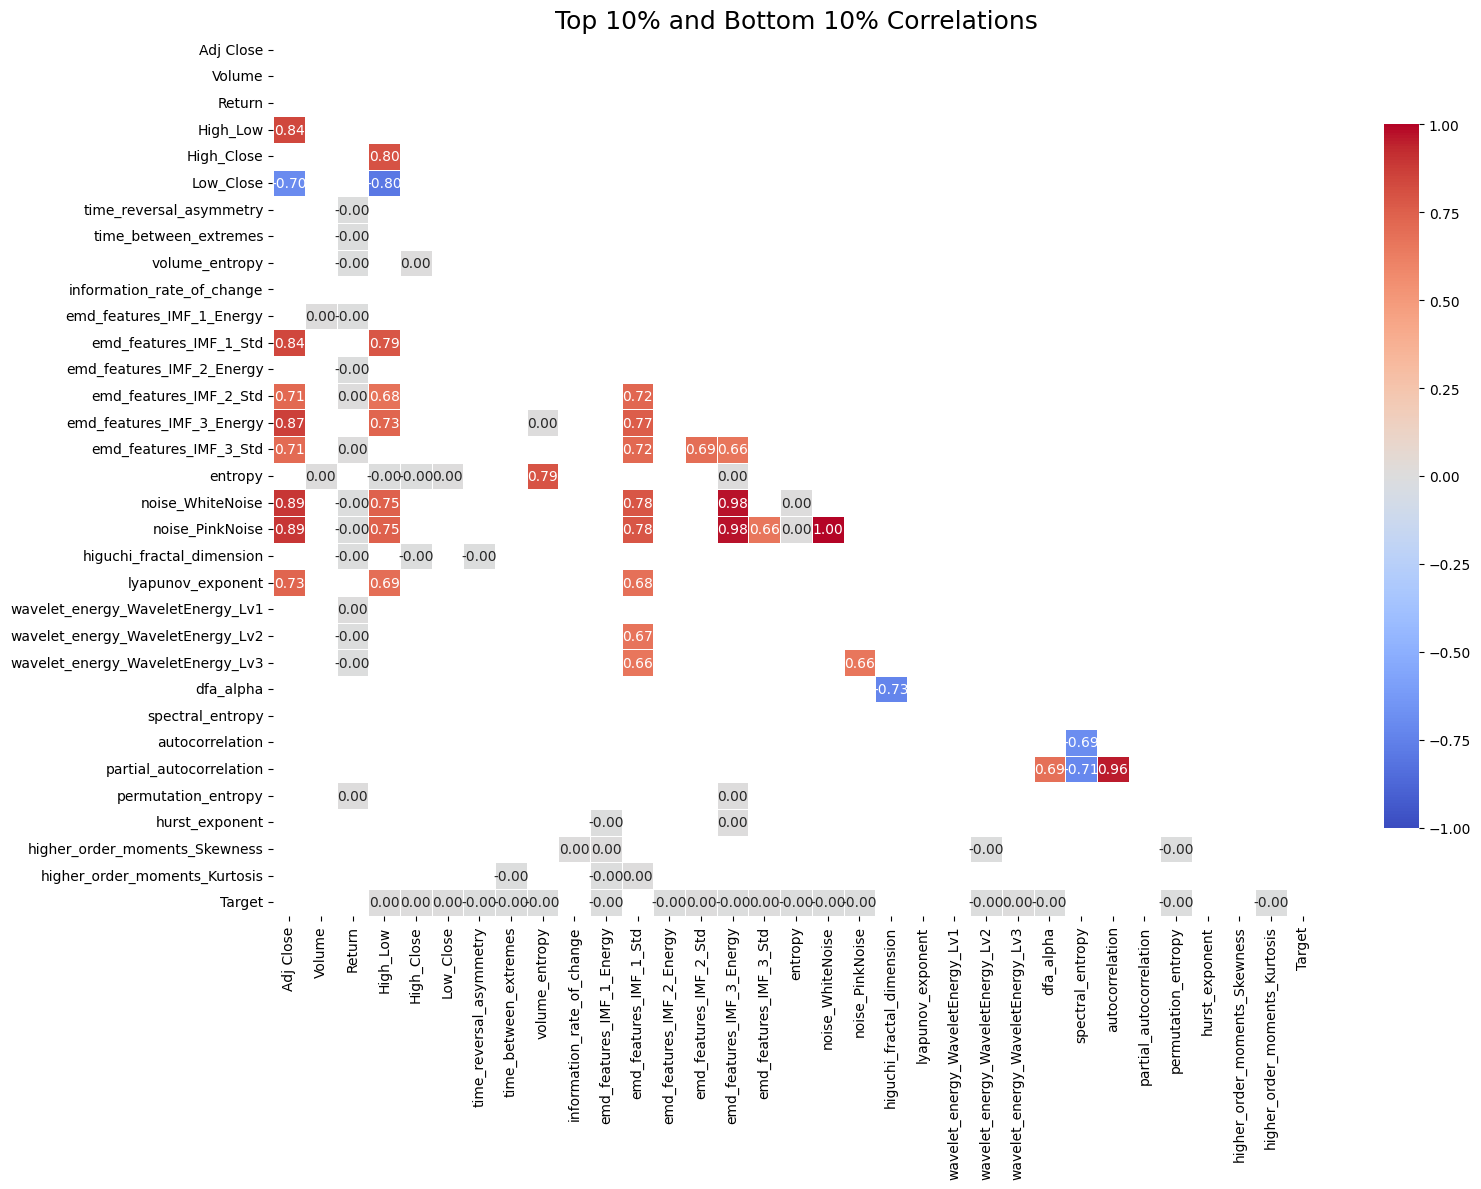

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_parquet('Z_Genetic_DataSet.parquet')

# Select only numerical columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

##remove the Open High Low Close columns to see better cors
numeric_df = numeric_df.drop(columns=['Open', 'High', 'Low', 'Close'])



# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Get the top and bottom 10% correlation thresholds using .iloc
cor_values = corr_matrix.abs().unstack().sort_values(kind="quicksort")
top_10_threshold = cor_values.iloc[int(len(cor_values) * 0.9)]
bottom_10_threshold = cor_values.iloc[int(len(cor_values) * 0.1)]

# Generate a mask for the upper triangle
upper_mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create the highlight mask for top and bottom 10% correlations
highlight = (corr_matrix.abs() >= top_10_threshold) | (corr_matrix.abs() <= bottom_10_threshold)

# Combine the masks - we want to show only the lower triangle AND the highlighted correlations
final_mask = upper_mask | ~highlight

# Set up the matplotlib figure
plt.figure(figsize=(16, 12))

# Draw the heatmap
sns.heatmap(
    corr_matrix, 
    mask=final_mask,  # Using the combined mask
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    vmax=1.0, 
    vmin=-1.0, 
    linewidths=0.5, 
    linecolor="white",
    cbar_kws={"shrink": .8}
)

plt.title("Top 10% and Bottom 10% Correlations", fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()